In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from numba import njit,prange
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from commonfunctions import *
from collections import defaultdict
from collections import Counter
from sklearn import svm
from sklearn import metrics
import seaborn as sns

from sklearn.linear_model import SGDClassifier

import joblib



In [16]:
%%capture
%run  letters_extraction.ipynb


In [17]:
model_0_1 , model_letters, model_all, model_E_F = 0,0,0,0
d = 0


In [18]:
winSize = (16,16)
blockSize = (8,8)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

In [19]:
def prepare_image(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image = get_letters(image)[0]
    return image

def images_resize(directory):
    list_target_names = []
    list_images = []
        
    for path, subdirs, files in os.walk(directory):
        if(path.startswith(directory + '.')):
            continue
        files = [f for f in files if not f[0] == '.'] # Ignore '.directory' file
        print(path, len(files))
        # limit = 600
        # if len(files) > limit:
        #     files = files[:limit]
            
        for name in files:
            image=cv2.imread(os.path.join(path, name))
            image = prepare_image(image)
            # image=cv2.resize(image, (100, 100))
            list_target_names.append(os.path.basename(path))
            list_images.append(image)
    
    return list_target_names,  list_images 
 

In [20]:
def load_data(directory):
    global d;
    Name=[]
    for file in os.listdir(directory):
        Name+=[file]
    
    #################################
    d = defaultdict(int)
    co = 0
    for x in sorted(os.listdir(directory)):
        if not x.startswith('.') and not d[x]:
            d[x] = co
            co+=1
    #########################
    target_names,images = images_resize(directory)
    #########################
    # c = Counter(sorted(target_names))
    # target_names = [ d[key] for key in target_names ]
    target_names_shuffled, images_shuffled = shuffle(np.array(target_names), np.array(images))
    
    ############reshaping#############
    n_samples,nx,ny= images_shuffled.shape
    # n_samples,nx,ny= np.array(images).shape
    
    images_shuffled2 = np.array([hog.compute(image)  for image in images_shuffled])

    images_shuffled2 = images_shuffled2.reshape(n_samples,-1)
    # images2 = images2.reshape(n_samples,-1)
        
    Xtrain, Xtest, ytrain, ytest = train_test_split(images_shuffled2, target_names_shuffled, random_state=0, test_size=0.2)
    # Xtrain, Xtest, ytrain, ytest = train_test_split(images2, target_names, train_size= 0.2, random_state=5, shuffle= True)
    
    return Xtrain, Xtest, ytrain, ytest 
    

In [21]:
def train_model( directory, filename, verbose = False, is_e_f = False):
    
    Xtrain, Xtest, ytrain, ytest = load_data(directory)

    ####### training #######
    if is_e_f :
        model = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
    else:
        model = svm.SVC(gamma = 0.001, C =100)
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    
    ########### save model ########
    joblib.dump(model, filename)
    
    if(verbose):
        # sns.set(rc={'figure.figsize':(15,12)})
        mat = confusion_matrix(ytest, ypred)
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=list(d.keys()), yticklabels=list(d.keys()))
        plt.xlabel('true label')
        plt.ylabel('predicted label')
        plt.show()
        
    return model

In [22]:
def initialize_models(verbose = False):
       global model_all;
       global model_0_1;
       global model_letters;
       global model_E_F;
       model_all =train_model(directory= './all_symbols/', filename = './saved_models/model_all.sav', verbose= verbose)        
       model_0_1 =train_model(directory= './0_1_symbols/', filename = './saved_models/model_0_1.sav', verbose= verbose)
       model_letters =train_model(directory= './letters_only_symbols/', filename = './saved_models/model_letters.sav', verbose= verbose)
       model_E_F =train_model(directory= './E_F_symbols/', filename = './saved_models/model_E_F.sav', verbose= verbose, is_e_f= True)
        

In [23]:
def load_models(is_expression = True, is_table = True):
    
    global model_all;
    global model_0_1;
    global model_letters;
    global model_E_F;
    if(is_table):
        model_0_1 = joblib.load('./saved_models/model_0_1.sav')
        model_letters = joblib.load('./saved_models/model_letters.sav')
        
    
    if(is_expression):
        model_all = joblib.load('./saved_models/model_all.sav')
    
    model_E_F = joblib.load('./saved_models/model_E_F.sav')

In [24]:
def classify(img, is_expression=False, is_0_1=False, is_letter=False, verbose = False):
    
    # print(img)
    letters_res = np.array(get_letters(img, verbose= verbose))

    
    hog_images = np.array([hog.compute(image)  for image in letters_res])
    # hog_images = np.array([cv2.cornerHarris(image, 2, 3, 0.04)  for image in letters_res])
    
    show_images([hog_images])
    # hog_images = hog.compute(img)
    if(is_letter):
        results =  model_letters.predict(hog_images)
        for i, r in enumerate(results):
            if r == 'E' or r == 'F':
                results[i] = model_E_F.predict([hog_images[i]])[0]
        return results
    
    if(is_0_1):
        return model_0_1.predict(hog_images)
    
    
    results =  model_all.predict(hog_images)
    for i, r in enumerate(results):
        if r == 'E' or r == 'F':
            results[i] = model_E_F.predict([hog_images[i]])[0]
    
    return results


In [25]:
# initialize_models()
load_models()

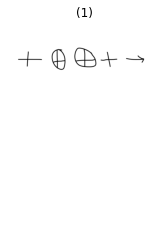

img shape: (2194, 1551), max=255, min=0,median=255.0 and type uint8
tolerance: 77.55000000000001


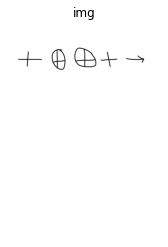

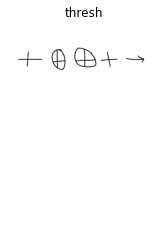

contours before area filtering
-971.0, -4443.5, -3083.0, -5643.0, 2497.5, 2815.0, 3436.0, -3751.0, -5721.0, -6102.0, 22268.5, -9495.5, 33333.0, -3399150.0, 
average_area 12870.0
average_width 191.6
average_height 157.6
contours after area filtering
2497.5, 2815.0, 3436.0, 22268.5, 33333.0, 
masks


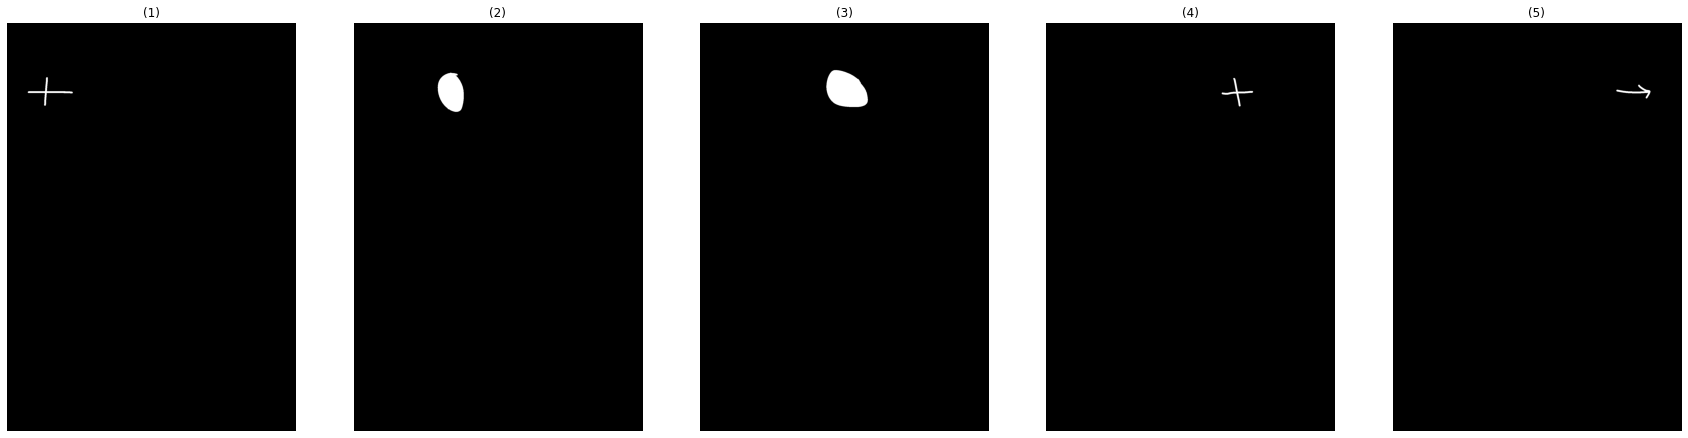

contours after merging


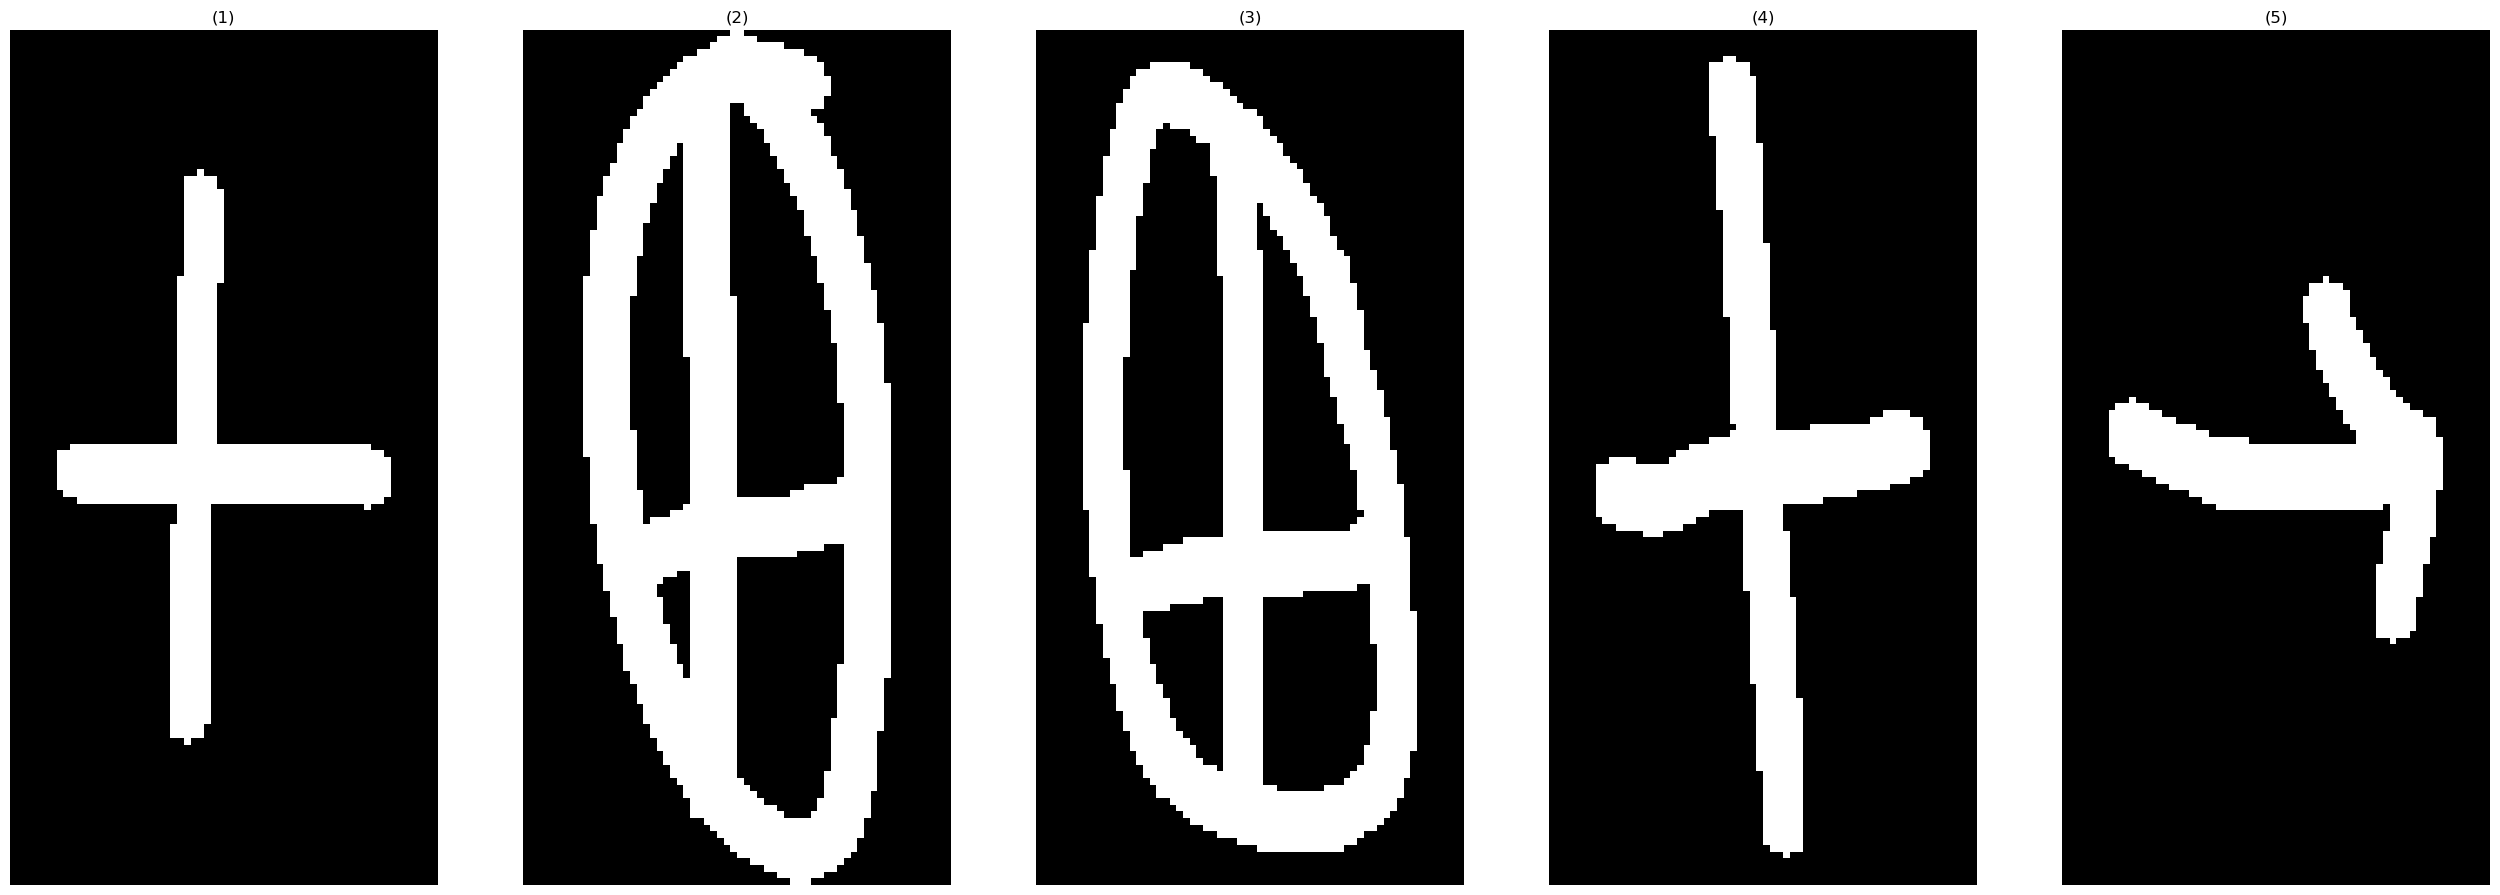

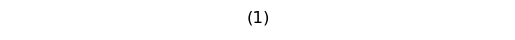

ValueError: X has 5184 features, but SVC is expecting 576 features as input.

In [26]:
letters= cv2.cvtColor(cv2.imread(r"./test_images/classification1.png"), cv2.COLOR_BGR2GRAY)
show_images([letters])
# letters_res = np.array(get_letters(letters, verbose= False))
# show_images(letters_res)

# letters_res = np.array([hog.compute(image) for image in letters_res])
# print(letters_res.shape)

results = classify( letters, is_expression=True, verbose=True) 

print(results)




In [31]:
# letters= cv2.cvtColor(cv2.imread(r"./test_images/ef.png"), cv2.COLOR_BGR2GRAY)
# show_images([letters])
# letters_res = np.array(get_letters(letters, verbose= False))
# show_images(letters_res)

# results = classify(letters_res, is_expression=True)
# print(results)

In [32]:
# letters= cv2.cvtColor(cv2.imread(r"./test_images/all.png"), cv2.COLOR_BGR2GRAY)
# show_images([letters])
# letters_res = np.array(get_letters(letters, verbose= False))
# show_images(letters_res)

# results = classify(letters_res, is_expression=True)
# print(results)